# Multi-Objective Optimization - 101

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/tutorials/blob/main/tutorials/colab/Multi_objective_optimization_101.ipynb)

In this tutorial, we will explore how to run black-box multi-objective optimization (MOO). In this setting, the goal is to resolve the following problem:

$$ \text{max}_x (f_0(x), f_1(x), ..., f_n(x)) $$

where $x$ is the set of optimized variables and $f_i$ are the different objectives. In DeepHyper, we use scalarization to transform such multi-objective problem into a single-objective problem:

$$ \text{max}_x s_w((f_0(x), f_1(x), ..., f_n(x))) $$

where $w$ is a set of weights which manages the trade-off between objectives and $s_w : \mathbb{R}^n \rightarrow \mathbb{R}$. The weight vector $w$ is randomized and re-sampled for each new batch of suggestion from the optimizer.



In [ ]:
# Installing DeepHyper if not present
try:
    import deephyper
    print(deephyper.__version__)
except (ImportError, ModuleNotFoundError):
    !pip install deephyper

# Installing DeepHyper/Benchmark if not present
try:
    import deephyper_benchmark as dhb
except (ImportError, ModuleNotFoundError):
    !pip install -e "git+https://github.com/deephyper/benchmark.git@develop#egg=deephyper-benchmark"

We will look at the DTLZ benchmark suite, a classic in multi-objective optimization (MOO) litterature. This benchmark exibit some characteristic cases of MOO. By default, this tutorial is loading the DTLZ-II benchmark which exibit a Pareto-Front with a concave shape.

In [1]:
import os

n_objectives = 2

# Configuration of the DTLZ Benchmark
os.environ["DEEPHYPER_BENCHMARK_DTLZ_PROB"] = str(2)
os.environ["DEEPHYPER_BENCHMARK_NDIMS"] = str(8)
os.environ["DEEPHYPER_BENCHMARK_NOBJS"] = str(n_objectives)
os.environ["DEEPHYPER_BENCHMARK_DTLZ_OFFSET"] = str(0.6)
os.environ["DEEPHYPER_BENCHMARK_FAILURES"] = str(0)

# Loading the DTLZ Benchmark
import deephyper_benchmark as dhb; dhb.load("DTLZ");
from deephyper_benchmark.lib.dtlz import hpo, metrics

We can display the variable search space of the benchmark we just loaded:

In [11]:
hpo.problem

Configuration space object:
  Hyperparameters:
    x0, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x1, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x2, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x3, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x4, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x5, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x6, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x7, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5

To define a black-box for multi-objective optimization it is very similar to single-objective optimization at the difference that the `objective` can now be a list of values. A first possibility is:


```python
def run(job):
    ...
    return objective_0, objective_1, ..., objective_n
```

which just returns the objectives to optimize as a tuple. If additionnal metadata are interesting to gather for each evaluation it is also possible to return them by following this format:

```python
def run(job):
    ...
    return {
        "objective": [objective_0, objective_1, ..., objective_n],
        "metadata": {
            "flops": ...,
            "memory_footprint": ...,
            "duration": ...,
        }
    }
```
each of the metadata needs to be JSON serializable and will be returned in the final results with a column name formatted as `m:metadata_key` such as `m:duration`.

Now we can load Centralized Bayesian Optimization search:

In [5]:
from deephyper.search.hps import CBO
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback

In [6]:
# Interface to submit/gather parallel evaluations of the black-box function.
# The method argument is used to specify the parallelization method, in our case we use threads.
# The method_kwargs argument is used to specify the number of workers and the callbacks.
# The TqdmCallback is used to display a progress bar during the search.
evaluator = Evaluator.create(
    hpo.run,
    method="thread",
    method_kwargs={"num_workers": 4, "callbacks": [TqdmCallback()]},
)

# Search algorithm
# The acq_func argument is used to specify the acquisition function.
# The multi_point_strategy argument is used to specify the multi-point strategy,
# in our case we use qUCB instead of the default cl_max (constant-liar) to reduce overheads.
# The update_prior argument is used to specify whether the sampling-prior should
# be updated during the search.
# The update_prior_quantile argument is used to specify the quantile of the lower-bound
# used to update the sampling-prior.
# The moo_scalarization_strategy argument is used to specify the scalarization strategy.
# Chebyshev is capable of generating a diverse set of solutions for non-convex problems.
# The moo_scalarization_weight argument is used to specify the weight of the scalarization.
# random is used to generate a random weight vector for each iteration.
search = CBO(
    hpo.problem,
    evaluator,
    acq_func="UCB",
    multi_point_strategy="qUCB",
    update_prior=True,
    update_prior_quantile=0.25,
    moo_scalarization_strategy="Chebyshev",
    moo_scalarization_weight="random",
    verbose=1,
)

# Launch the search for a given number of evaluations
# other stopping criteria can be used (e.g. timeout, early-stopping/convergence)
results = search.search(max_evals=500)

/Users/romainegele/Documents/Argonne/deephyper/deephyper/evaluator/_evaluator.py:127: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

A Pandas table of results is returned by the search and also saved at `./results.csv`. An other location can be specified by using `CBO(..., log_dir=...)`.

In [9]:
results

,p:x0,p:x1,p:x2,p:x3,p:x4,p:x5,p:x6,p:x7,objective_0,objective_1,job_id,m:timestamp_submit,m:timestamp_gather,m:timestamp_start,m:timestamp_end,pareto_efficient
0,0.850100,0.391847,0.122471,0.424050,0.500232,0.004699,0.185229,0.605322,-4.289602e-01,-1.787985,0,0.024188,0.024887,1.689757e+09,1.689757e+09,False
1,0.987131,0.443025,0.605100,0.729512,0.202744,0.583537,0.820346,0.951153,-2.771908e-02,-1.371105,1,0.024201,0.038303,1.689757e+09,1.689757e+09,False
2,0.676791,0.435216,0.597024,0.261991,0.370516,0.524626,0.996994,0.109766,-7.767411e-01,-1.396169,3,0.024218,0.038470,1.689757e+09,1.689757e+09,False
3,0.306905,0.052690,0.147246,0.929035,0.122620,0.260607,0.843341,0.343706,-1.843632e+00,-0.964707,2,0.024210,0.038648,1.689757e+09,1.689757e+09,False
4,0.501746,0.807243,0.788074,0.696304,0.692358,0.068283,0.001372,0.880210,-1.280383e+00,-1.287427,4,0.078767,0.079583,1.689757e+09,1.689757e+09,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.000000,0.595345,0.613626,0.594558,0.589132,0.654703,0.585816,0.588816,-6.145729e-17,-1.003674,494,43.064424,43.065386,1.689757e+09,1.689757e+09,False
496,0.939568,0.562704,0.600104,0.378808,0.604737,0.572510,0.543134,0.590974,-9.994181e-02,-1.049663,496,43.465104,43.465510,1.689757e+09,1.689757e+09,False
497,0.785354,0.000000,0.627249,0.568532,0.611970,0.629120,0.624435,0.691596,-4.537791e-01,-1.294479,499,43.465125,43.465823,1.689757e+09,1.689757e+09,False
498,1.000000,0.579668,0.636207,0.613580,0.619346,0.663030,0.597623,0.573388,-6.165910e-17,-1.006970,498,43.465119,43.465972,1.689757e+09,1.689757e+09,False


In this table we retrieve:

- columns starting by `p:` which are the optimized variables.
- the `objective_{i}` are the objectives returned by the black-box function.
- the `job_id` is the identifier of the executed evaluations.
- columns starting by `m:` are metadata returned by the black-box function.
- `pareto_efficient` is a column only returned for MOO which specify if the evaluation is part of the set of optimal solutions.

Let us use this table to visualized evaluated objectives:

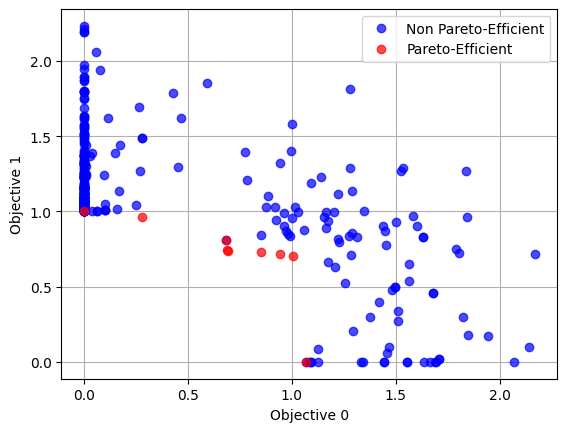

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    -results[~results["pareto_efficient"]]["objective_0"],
    -results[~results["pareto_efficient"]]["objective_1"],
    "o",
    color="blue",
    alpha=0.7,
    label="Non Pareto-Efficient",
)
plt.plot(
    -results[results["pareto_efficient"]]["objective_0"],
    -results[results["pareto_efficient"]]["objective_1"],
    "o",
    color="red",
    alpha=0.7,
    label="Pareto-Efficient",
)
plt.grid()
plt.legend()
plt.xlabel("Objective 0")
plt.ylabel("Objective 1")
plt.show()